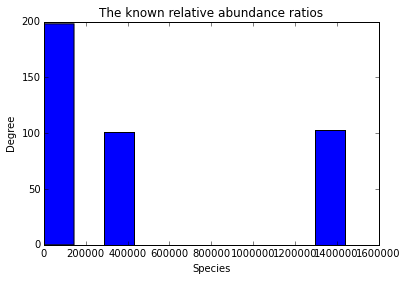

The number of topics = 4
The number of words in the vocab= 9
The total number of documents= 4
The number of words in document = [99, 99, 99, 99]
The number of words in all documents = 396
 [----             12%                  ] 1250 of 10000 complete in 34.4 sec

In [ ]:
from pandas import *
import numpy as np
from matplotlib import *
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import pickle
import pymc as pm
prep_data = pickle.load(open('input.p', "rb" ) )
prep_data['Tax ID'].plot(kind='hist') # show truth abundance ratios
plt.title('The known relative abundance ratios')
plt.xlabel('Species')
plt.show()
###################################################################################################################
################################                 LOAD DATA                 ########################################
###################################################################################################################
data = pickle.load(open('data.p', "rb" ) )

###################################################################################################################
################################                 SET VARIABLES                 ####################################
###################################################################################################################
K = 4 # Number of topics , this is our Food or Pet topics, this would be limited to species -for first mock test 4
V = len(prep_data['Tax ID'].unique())  # The total number of words in the vocabulary ( this would be all taxa) 
# it is still unclear whether this should be all 
M = len(data) # = len(data) #number of documents 
Wd = [len(doc) for doc in data] #number of words in documents Nd = 1,..., M
N = 0 #the total number of words in all documents
for i in data:
    N = N + len(i)


alpha = np.ones(K)
beta = np.ones(V) - .99
print 'The number of topics =', K
print 'The number of words in the vocab=', V
print 'The total number of documents=', M
print 'The number of words in document =', Wd
print 'The number of words in all documents =', N


###################################################################################################################
################################                PyMC code                      ####################################
###################################################################################################################

phi = pm.Container([pm.CompletedDirichlet("phi_%s" % k, pm.Dirichlet("pphi_%s" % k, theta=beta)) for k in range(K)])
theta = pm.Container([pm.CompletedDirichlet("theta_%s" % i, pm.Dirichlet("ptheta_%s" % i, theta=alpha)) for i in range(M)])
z = pm.Container([pm.Categorical('z_%i' % d, 
                 p = theta[d], 
                 size=Wd[d],
                 value=np.random.randint(K, size=Wd[d]))
              for d in range(M)])

w = pm.Container([pm.Categorical("w_%i_%i" % (d,i),
                p = pm.Lambda('phi_z_%i_%i' % (d,i), 
                          lambda z=z[d][i], phi=phi: phi[z]),
                value=data[d][i], 
                observed=True)
              for d in range(M) for i in range(Wd[d])])

###################################################################################################################
################################                PyMC model                    ####################################
###################################################################################################################

model = pm.Model([theta, phi, z, w])
mcmc = pm.MCMC(model)
mcmc.sample(iter=10000, burn=1000, thin=10)

###################################################################################################################
################################                PyMC output                    ####################################
###################################################################################################################

theta_list = []
for i in range(0,M):
    var = 'theta_'+str(i)
    theta_list.append(np.round(mcmc.stats(var)[var]['mean'].tolist(),4))

phi_list = []
for i in range(0,K):
    var = 'phi_'+str(i)
    phi_list.append(np.round(mcmc.stats(var)[var]['mean'].tolist(),4))

z_list = []
for i in range(0,K):
    var = 'z_'+str(i)
    z_list.append(mcmc.stats(var)[var]['mean'].tolist())

print "Z:  The identity of topic of word w in document d"
print np.array(z_list)

print "THETA:  distribution of topics in document d" 
print np.array(theta_list)

print "PHI:  probability of words in topic D"
print np.array(phi_list)

###################################################################################################################
################################                PyMC plotting                    ##################################
###################################################################################################################

from pymc.Matplot import plot as mcplot

mcplot(mcmc)
